# Tangles-CNN Training Notebook

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat_gmm import *

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.10.1+cu111
Torchvision Version:  0.10.1
CUDA status:  True
CUDA memory max alloc:        0 MB


## Model Setup
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
# exp_dir = "/home/pyushkevich/data/thon2019_reorg/exp02_multiclass"
# exp_dir = "/data/pauly2/wildcat/data/thon2019/exp03_threads"
exp_dir = "/data/pauly2/wildcat/data/thon2019/exp04_multilabel"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps

# new num_maps formulation
config = {
    "num_classes": 3,
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": [1,1,1],
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 32
    }
}

## Model instantiation and training

In [3]:
# Instantiate WildCat model
data_dir = os.path.join(exp_dir, "patches")
# data_dir = '/home/pyushkevich/data/thon2019/exp01/fold_HNL-11-15'

model = UNet_WSL_GMM_2(
    num_classes = config['num_classes'],
    mix_per_class=config['wildcat_upsample']['num_maps'], 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'],
    tunable_class_pooling=False)

In [4]:
# Loss and optimizer
# criterion = nn.MultiLabelSoftMarginLoss()

# We use BCE loss because network outputs are probabilities, and this loss
# does log clamping to prevent infinity or NaN in the gradients
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=config['wildcat_upsample']['batch_size'], 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

tensor([0, 1, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2,
        2, 1, 2, 1, 1, 1, 1, 2])

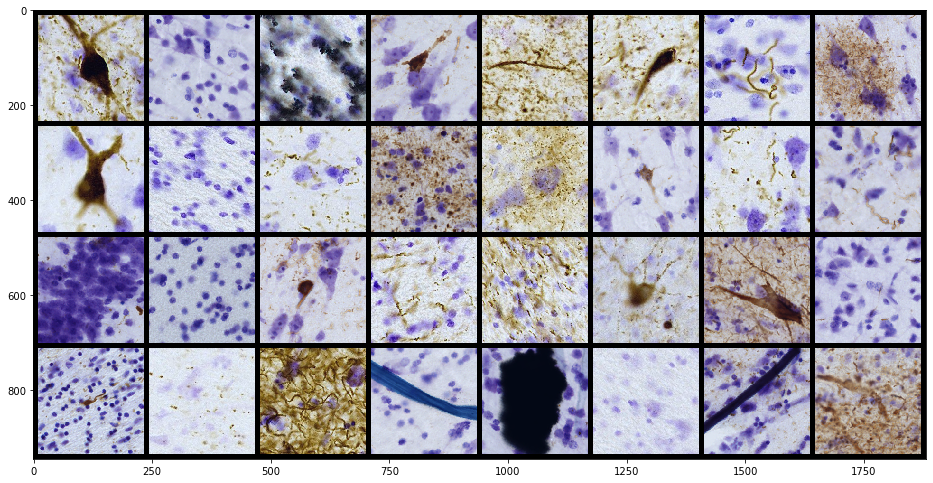

In [5]:
# Read a batch of data from the training data loader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img,label=next(iter(dataloaders_dict['train']))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label

In [6]:
# Load previous model?

In [7]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:1


In [8]:
# Here is the mapping from labels to indices
image_datasets['train'].class_to_idx

{'inclusions': 0, 'non-threads': 1, 'threads': 2}

In [9]:
# Define a special criterion for multi-label situation
def clog(x):
    return torch.clamp(torch.log(x),-100)

def thread_loss_full(y, labels):
    i0,i1,i2 = labels == 0, labels == 1, labels == 2
    x0 = torch.sum(clog(y[i0,0]) + clog(1 - y[i0,1]) + clog(1 - y[i0,2]))
    x1 = torch.sum(clog(y[i1,1]) + clog(1 - y[i1,0]) + clog(1 - y[i1,2]))
    x2 = torch.sum(clog(y[i2,2]) + clog(1 - y[i2,0]) + clog(1 - y[i2,1]))
    return -(x0 + x1 + x2) / (y.shape[0] * y.shape[1])

def thread_loss_partial(y, labels):
    """No penalty on high response from thread class when label is tangle/inclusion"""
    i0,i1,i2 = labels == 0, labels == 1, labels == 2
    
    # Inclusions
    x0 = torch.sum(clog(y[i0,0]) + clog(1 - y[i0,1]))
    
    # Background
    x1 = torch.sum(clog(y[i1,1]) + clog(1 - y[i1,0]) + clog(1 - y[i1,2]))
    
    # Threads
    x2 = torch.sum(clog(y[i2,2]) + clog(1 - y[i2,0]) + clog(1 - y[i2,1]))
    
    return -(x0 + x1 + x2) / (y.shape[0] * y.shape[1])

def thread_loss_partial_2(y, labels):
    """No penalty on high response from thread class when label is tangle/inclusion"""
    i0,i1,i2 = labels == 0, labels == 1, labels == 2
    
    # Inclusions
    x0 = torch.sum(clog(y[i0,0]))
    
    # Background
    x1 = torch.sum(clog(y[i1,1]) + clog(1 - y[i1,0]) + clog(1 - y[i1,2]))
    
    # Threads
    x2 = torch.sum(clog(y[i2,2]) + clog(1 - y[i2,1]))
    
    return -(x0 + x1 + x2) / (y.shape[0] * y.shape[1])

In [10]:
# Try the model on one minibatch
with torch.set_grad_enabled(False):
    x = img.to(device)
    z = model(x)

z

tensor([[0.9756, 0.9868, 1.0000],
        [0.8202, 0.9867, 1.0000],
        [0.6348, 0.5202, 0.9989],
        [0.9992, 0.9853, 0.9999],
        [0.6139, 0.6340, 1.0000],
        [0.9212, 0.9896, 0.9999],
        [0.9509, 0.9969, 0.9999],
        [0.9858, 0.9538, 0.9811],
        [0.9700, 0.9984, 1.0000],
        [0.8735, 0.9723, 0.9996],
        [0.9497, 0.9976, 0.9997],
        [0.9853, 0.9600, 0.9701],
        [0.7873, 0.8487, 0.9989],
        [0.9989, 0.9955, 0.9998],
        [0.9982, 0.9932, 0.9998],
        [0.9853, 0.9212, 1.0000],
        [0.9989, 0.9827, 0.9902],
        [0.9762, 0.7336, 1.0000],
        [0.8926, 0.9950, 0.9999],
        [0.8979, 0.9934, 0.9998],
        [0.8176, 0.8566, 0.9998],
        [0.9131, 0.9564, 1.0000],
        [0.9873, 0.9861, 1.0000],
        [0.9696, 0.9920, 0.9980],
        [0.4728, 0.6700, 1.0000],
        [0.9993, 0.9984, 0.9329],
        [0.8668, 0.9981, 0.9907],
        [0.9655, 0.9961, 1.0000],
        [0.9899, 1.0000, 0.9998],
        [0.999

In [11]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Track loss and accuracy per minibatch
            mb_loss, mb_acc = [], []

            # Iterate over data.
            for mb, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # COMMENTEd OUT FOR CUSTOM LOSS FN
                # labels_one_hot = torch.zeros([labels.shape[0], config['num_classes']])
                # for k in range(config['num_classes']):
                #    labels_one_hot[:,k] = (labels==k)
                # labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = thread_loss_partial_2(outputs, labels)
                    
                    # loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Append accuracy scores and loss 
                n = inputs.size(0)
                c_loss, c_acc = loss.item(), torch.sum(preds == labels.data).item() / n
                mb_loss.append(c_loss)
                mb_acc.append(c_acc)
                
                # Print minimatch stats
                if mb > 0 and mb % 10 == 0:
                    print('MB %04d/%04d  loss %8.4f  corr %4.2f' %
                          (mb, len(dataloaders[phase]), 
                           np.mean(mb_loss[-10:]), np.mean(mb_acc[-10:])))
                        
                # statistics
                running_loss += c_loss * n
                running_corrects += c_acc * n

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
            # Save a copy of the model
            torch.save(model.state_dict(), '/tmp/checkpt_multi_%03d.pt' % (epoch,))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
# Train and evaluate
# model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])
# model.load_state_dict(torch.load('/tmp/checkpt_multi_009.pt'))
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
MB 0010/0094  loss   1.4028  corr 0.39
MB 0020/0094  loss   1.6653  corr 0.34


ValueError: Expected parameter loc (Tensor of shape (32, 3, 3)) of distribution MultivariateNormal(loc: torch.Size([32, 3, 3]), covariance_matrix: torch.Size([32, 3, 3, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]], device='cuda:1', grad_fn=<ExpandBackward0>)

In [14]:
# Load previous model?
model.load_state_dict(torch.load('/tmp/checkpt_multi_014.pt'))
# model.load_state_dict(torch.load('/home/pyushkevich/data/thon2019_reorg/exp02_multiclass/models/wildcat_upsample.dat'))
# model.load_state_dict(torch.load(os.path.join(exp_dir, 'models/wildcat_upsample.dat')))

<All keys matched successfully>

In [68]:
img,label=next(iter(dataloaders_dict['val']))
x = img.to(device)

labels_one_hot = torch.zeros([label.shape[0], config['num_classes']])
for k in range(config['num_classes']):
    labels_one_hot[:,k] = (label==k)
labels_one_hot = labels_one_hot.to(device)

with torch.set_grad_enabled(False):
    y=model.softmax(model.unet(x))
    z=y
    for g in model.gmm: 
        z = g(z,x)
    
    cp = model.classwise_pooling(z)
    z2 = model.spatial_pooling(cp)
    sp = model.softmax_pooled(z2) if model.softmax_pooled is not None else z2
    
    # Apply spatial pooling to the probabilities (take average of max-values)
    # z1 = model.spatial_pooling(z)
        
    # Apply the linear transformation to mix probabilities for classification
    # z2 = model.fc_pooled(z1)
    #sp = model.softmax_pooled(z2)
    
    #cp = torch.softmax((torch.matmul(z.permute(0,2,3,1), model.fc_pooled.weight.permute(1,0)) + model.fc_pooled.bias.view(1,1,1,-1)).permute(0,3,1,2),1)
    # cp = model.classwise_pooling(z) * config['wildcat_upsample']['num_maps']
    
    # cp = model.classwise_pooling(z) * 4
    # sp = model.spatial_pooling(cp)
    
_, preds = torch.max(sp, 1)
# criterion(sp, labels_one_hot).item(), sum(preds.cpu() == label).item()
thread_loss_partial(sp, label.to(device))

tensor(0.5132, device='cuda:1')

In [69]:
for k in range(sp.shape[0]):
    print(sp[k,:].cpu().detach().numpy(), label[k].item())

[0.28624624 0.43194315 0.28181058] 1
[0.428523   0.29524288 0.27623406] 0
[0.27604878 0.3150711  0.40888014] 2
[0.41505128 0.272067   0.3128817 ] 0
[0.23388745 0.31028378 0.4558288 ] 2
[0.39406788 0.26617238 0.33975968] 0
[0.43528125 0.31197947 0.25273925] 0
[0.44734773 0.28872815 0.26392412] 2
[0.2663589  0.34342963 0.39021137] 1
[0.27080992 0.30456102 0.424629  ] 1
[0.25362659 0.4103239  0.33604956] 1
[0.28394553 0.4261613  0.28989324] 1
[0.22541949 0.3064437  0.46813682] 2
[0.4261487 0.3038748 0.2699765] 0
[0.4425813  0.31015408 0.24726467] 0
[0.27541125 0.31445944 0.41012928] 2
[0.23940258 0.30732608 0.45327136] 1
[0.43216473 0.27519432 0.29264092] 0
[0.28156826 0.45438087 0.26405084] 2
[0.28333947 0.41061074 0.30604985] 1
[0.29975462 0.3527394  0.347506  ] 1
[0.24480869 0.35122395 0.40396738] 1
[0.32905525 0.44924003 0.2217047 ] 1
[0.24591632 0.32593727 0.42814642] 2
[0.39700174 0.27536386 0.3276344 ] 0
[0.23439735 0.31063727 0.45496538] 2
[0.28919572 0.43555424 0.27525005] 1
[0.3

In [70]:
model.classwise_pooling.weights

Parameter containing:
tensor([[ 0.7906,  1.2517, -0.0427, -0.0264, -0.0589, -0.0383, -0.0425, -0.0599],
        [ 0.0100,  0.0127,  0.8368,  0.7309,  0.8669,  0.9591,  0.0079,  0.0124],
        [-0.0479, -0.0454, -0.0356, -0.0295, -0.0396, -0.0285,  1.0713,  0.8982]],
       device='cuda:1', requires_grad=True)

In [71]:
def img_unnorm(img):
    return torch.clamp(
        torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3,1,1) * img 
        + torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3,1,1),
        0, 1)

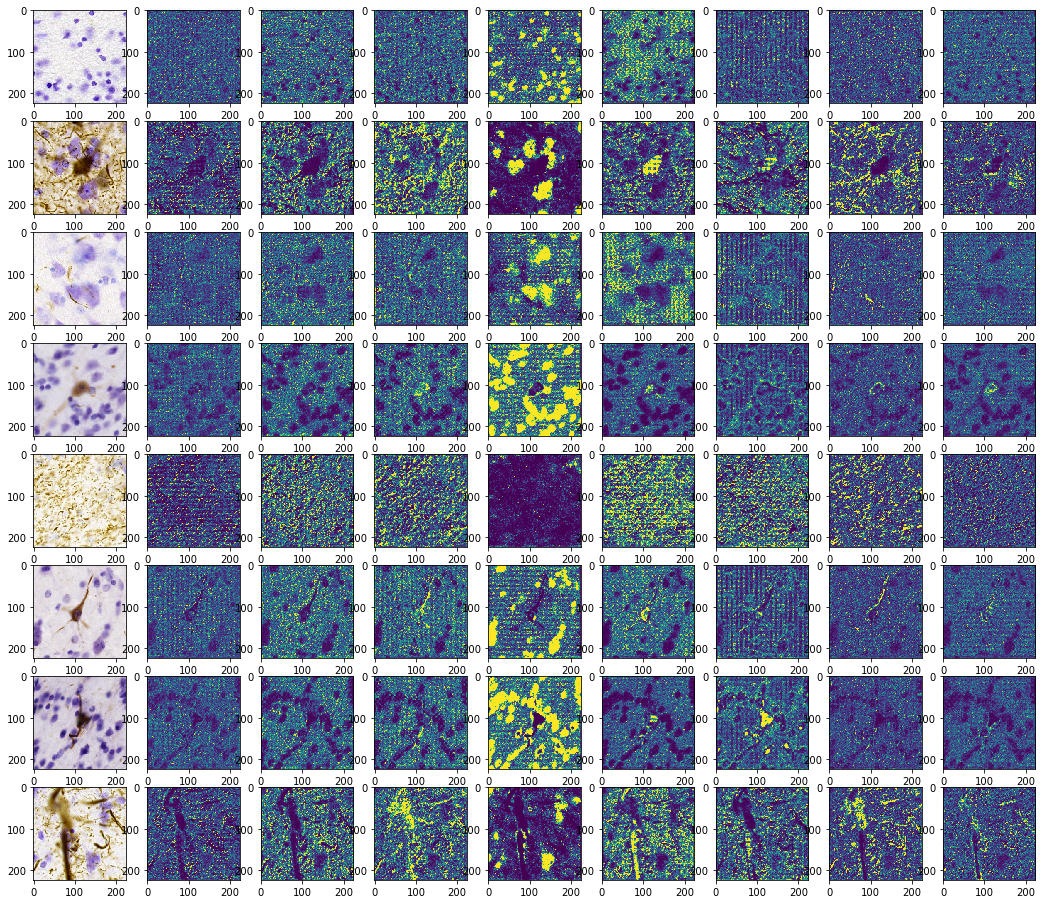

In [72]:
# Batches/channels to show
nnb = np.min([8, z.shape[0]])
nnc = np.min([16, z.shape[1]])

plt.figure(figsize=((1+nnc) * 2, nnb * 2))
for b in range(nnb):
    plt.subplot(nnb, (1+nnc), (1+nnc)*b + 1)
    plt.imshow(img_unnorm(x[b,:,:,:]).permute(1,2,0).detach().cpu().numpy())
    for k in range(nnc):
        plt.subplot(nnb, (1+nnc), (1+nnc)*b + k + 2)
        plt.imshow(y[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=0.4)

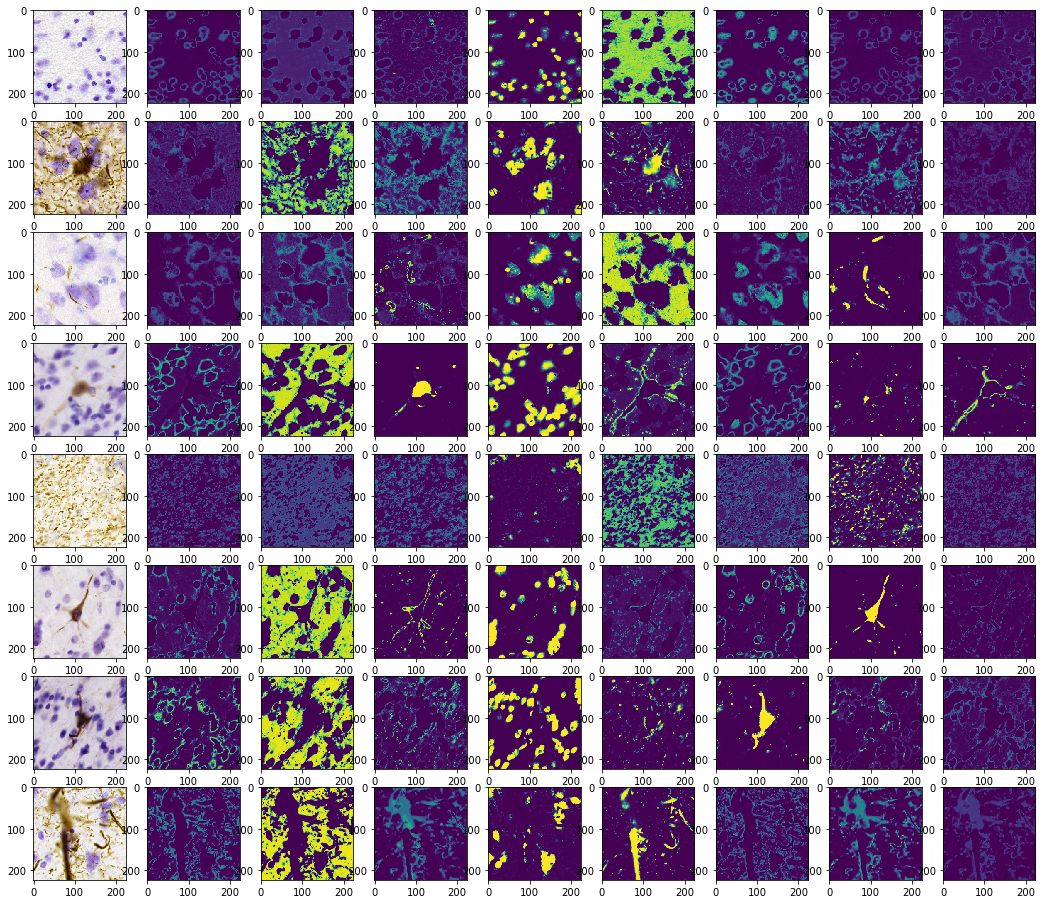

In [73]:
plt.figure(figsize=((1+nnc) * 2, nnb * 2))
for b in range(nnb):
    plt.subplot(nnb, (1+nnc), (1+nnc)*b + 1)
    plt.imshow(img_unnorm(x[b,:,:,:]).permute(1,2,0).detach().cpu().numpy())
    for k in range(nnc):
        plt.subplot(nnb, (1+nnc), (1+nnc)*b + k + 2)
        plt.imshow(z[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=1)

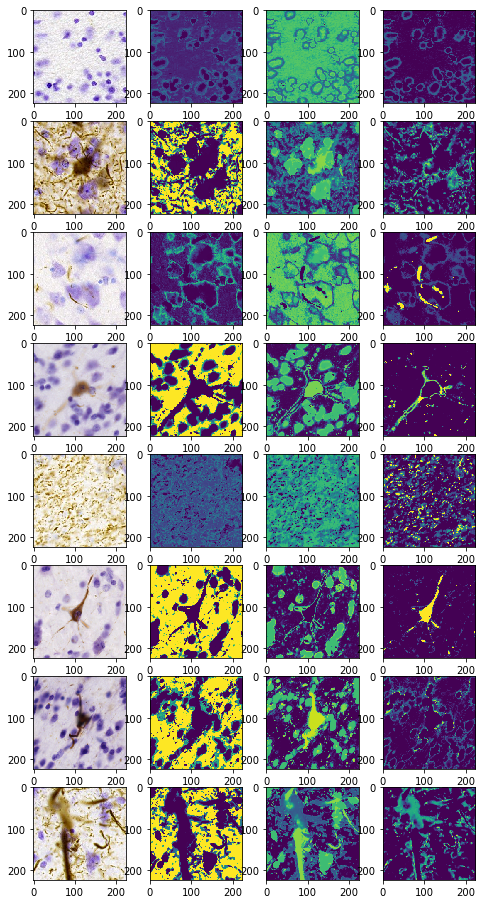

In [74]:
nnk = cp.shape[1]
plt.figure(figsize=((1+nnk) * 2, nnb * 2))
for b in range(nnb):
    plt.subplot(nnb, (1+nnk), (1+nnk)*b + 1)
    plt.imshow(img_unnorm(x[b,:,:,:]).permute(1,2,0).detach().cpu().numpy())
    for k in range(nnk):
        plt.subplot(nnb, (1+nnk), (1+nnk)*b + k + 2)
        plt.imshow(cp[b,k,:,:].squeeze().detach().cpu().numpy(), vmin=0.0, vmax=1)

In [75]:
model.classwise_pooling.weights

Parameter containing:
tensor([[ 0.7906,  1.2517, -0.0427, -0.0264, -0.0589, -0.0383, -0.0425, -0.0599],
        [ 0.0100,  0.0127,  0.8368,  0.7309,  0.8669,  0.9591,  0.0079,  0.0124],
        [-0.0479, -0.0454, -0.0356, -0.0295, -0.0396, -0.0285,  1.0713,  0.8982]],
       device='cuda:1', requires_grad=True)

In [76]:
srt, idx = torch.sort(cp[0,0,:,:].view(-1))

In [71]:
torch.mean(srt[-srt.shape[0]//50:])

tensor(0.4414, device='cuda:1')

In [72]:
sp[0]

tensor([0.6722, 0.1111, 0.2168], device='cuda:1')

In [73]:
config

{'num_classes': 3,
 'wildcat_upsample': {'kmax': 0.02,
  'kmin': 0.0,
  'alpha': 0.7,
  'num_maps': 4,
  'input_size': 224,
  'num_epochs': 30,
  'batch_size': 32}}

In [84]:
qq=nn.Sequential(nn.Conv2d(3,8,3,padding=1), nn.Conv2d(8,8,3,padding=1)).to(device)
with torch.no_grad():
    img1 = qq(x)

In [85]:
img1.shape

torch.Size([32, 8, 224, 224])

## Export model

In [27]:
model_ft=model

In [28]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.state_dict(), os.path.join(model_dir, "wildcat_upsample_ep120.dat"))

# Save the configuration
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Model performance over epochs

In [34]:
plt.plot(hist)

NameError: name 'hist' is not defined

In [12]:
del model_ft
torch.cuda.empty_cache()

In [13]:
!nvidia-smi

Mon Dec 14 16:12:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    49W / 250W |   2079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------